# EAE 127 - Project 5: Airfoil Performance

Chung Yin Leung (998238900)

---

Imports and setup code:

In [2]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as pl
%matplotlib inline

---

## Introduction

In this project, source panels is repurposed for a ground vehicle and the performance of several airfoils is examined. A car is modeled using source panels in order to determine locations of undisturbed flow such that a sensor can be mounted. The airfoils' lift and drag coefficients data are generated using XFOIL. The data are plotted and compared, and data for specific angles of attack are also compared.

---

### Problem 1: Car Source Panel Method

#### Approach

A car traveling at 25 mph is modeled using source panels. The Panel class and a majority of the panel functions from Project 4 are reused. The geometry of the car is formed using circular arc and line segments. By defining functions for each and using the Panel class, sets of panels across the arcs and lines are created to form the geometry of the car. And in order to model the ground, a mirror of the geometry is formed such that the ground is a streamline.

Just like in Project 4, the source strengths of the set of panels are calculated and then the tangential velocity across the surface is calculated. The source strengths are used to calculate the x and y flow velocities across a mesh grid. Using the velocities, the flow field is plotted.

A sensor must be placed at a location in undisturbed flow. The given criteria is that the x-component of the flow velocity ($u$) must be less than $1.01$ of the freestream velocity ($U_\infty$). Given that flow near the stagnation point of the car will have $u$ less than $U_\infty$, I changed the criteria to be that $u$ is within 1% of $U_\infty$. In addition to $u$ being less than $(1.01)U\infty$, $u$ must also be greater than $(0.99)U\infty$ for the flow to be considered undisturbed. When checking for the vertical distance from the vehicle's center to undisturbed flow, the original criteria is used because $u$ is greater than $U_\infty$. When checking for the horizontal distance from the vehicle's center to undisturbed flow, the new criteria is used because $u$ is less than $U_\infty$.

For finding both the vertical distance and the horizontal distance, an iterative method is used, where the error is set to be the absolute value of the difference between $u$ and $U_\infty$. $u$'s are calculated across a y or x bound along the vertical or horizontal line. The $u$'s are checked against the criteria. If the $u$'s do not satisfy the criteria, the bounds are incremented away from the car and the calculations are redone. If there exists a $u$ that satisfies the criteria, the location of the $u$ that is closest to the car and that satisfies the criteria is used to set new y or x bounds. The error is then calculated and checked against a tolerance. If the error is greater than the tolerance, another iteration begins.

To help in finding locations of undisturbed flow, $\frac{u}{U_\infty}$ is calculated across the mesh grid, and lines where $\frac{u}{U_\infty}$ is 1.00, 1.01 and 0.99 are plotted. Because of the inaccuracies of the mesh grid near the surface, exact locations of undisturbed flow across the surface is also found. $u$ across the surface is found by decomposing the tangential velocity across the surface. The tangential velocity is decomposed using a trigonometric relation of the panel's normal's angle with x-axis. 

#### Equations

The function below defines the integral that follows:

$$
\int 
\frac
{\left(x_{c_i}-x_j(s_j)\right)\cos\beta_i + \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i}
{\left(x_{c_i}-x_j(s_j)\right)^2 + \left(y_{c_i}-y_j(s_j)\right)^2} 
{\rm d}s_j
$$

This is used to evaluate the normal velocity at each source panel.

In [2]:
def integral_normal(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the normal direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
        return ( (+(p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))*np.cos(p_i.beta)
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))*np.sin(p_i.beta))
                /((p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., p_j.length)[0]

In matrix notation, the source strengths can be written as follows:

$$
\boldsymbol{\rm A}\vec{\sigma} = \vec{b}
$$

And $\boldsymbol{\rm A}$ and $\vec{b}$ are defined as follows:

$$A_{ij} = \begin{cases}
\begin{matrix}
\frac{1}{2} & , i=j \cr
\frac{1}{2\pi} \int \frac{
\left(x_{c_i}-x_j(s_j)\right) \cos\beta_i
+ \left(y_{c_i}-y_j(s_j)\right) \sin\beta_i
}
{\left(x_{c_i}-x_j(s)\right)^2 + \left(y_{c_i}-y_j(s)\right)^2} ds_j & , i\neq j
\end{matrix}
\end{cases}$$

$$b_i = - U_\infty \cos\beta_i$$


This system of equations is solved by the defined function below:

In [3]:
def panels_strength(panels,u_inf):
    """Evaluates the source strength of each panel and stores in each Panel object.
    
    Arguments
    ---------
    panels -- a list of Panel objects
    
    Returns
    -------
    sigma -- a list of source strength values for each panel
    """
    N_panels = len(panels)
    # computes the source influence matrix
    A = np.empty((N_panels, N_panels), dtype=float) #Initializes an empty A matrix
    np.fill_diagonal(A, 0.5) #Aii is 1/2

    #For-loop fills in Aij according to equation
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = (0.5/np.pi)*integral_normal(p_i, p_j)

    # computes the RHS of the linear system
    b = - u_inf * np.cos([p.beta for p in panels])

    # solves the linear system
    sigma = np.linalg.solve(A, b)

    #For-loop sets the source strength of each panel
    for i, panel in enumerate(panels):
        panel.sigma = sigma[i]
        
    return sigma

The function below defines the integral that follows:

$$
\int \frac
{-\left(x_{c_i}-x_j(s_j)\right)\sin\beta_i +
\left(y_{c_i}-y_j(s_j)\right) \cos\beta_i}
{\left(x_{c_i}-x_j(s_j)\right)^2 + \left(y_{c_i}-y_j(s_j)\right)^2} 
{\rm d}s_j
$$

This is used to evaluate the tangential velocity at each source panel.

In [4]:
def integral_tangential(p_i, p_j):
    """Evaluates the contribution of a panel at the center-point of another,
    in the tangential direction.
    
    Arguments
    ---------
    p_i -- panel on which the contribution is calculated.
    p_j -- panel from which the contribution is calculated.
    
    Returns
    -------
    Integral over the panel of the influence at a control-point.
    """
    def func(s):
        return ( (-(p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))*np.sin(p_i.beta)
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))*np.cos(p_i.beta))
                /((p_i.xc-(p_j.xa-np.sin(p_j.beta)*s))**2
                  +(p_i.yc-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s),0.,p_j.length)[0]

The following is a system of equations for the tangential velocity:

$$
\vec{u_t} = \boldsymbol{\rm C}\vec{\sigma} + \vec{d}
$$

And $\boldsymbol{\rm C}$ and $\vec{d}$ are defined as follows:

$$C_{ij} =
\frac{\sigma_j}{2\pi} 
\int \frac
{-\left(x_{c_i}-x_j(s_j)\right)\sin\beta_i + \left(y_{c_i}-y_j(s_j)\right) \cos\beta_i}
{\left(x_{c_i}-x_j(s_j)\right)^2 + \left(y_{c_i}-y_j(s_j)\right)^2} 
{\rm d}s_j
$$

$$d_i = - U_\infty \sin\beta_i$$

When the integral is evaluated for a panel's contribution to the tangential velocity of itself, the result will be zero because steamlines only go outward from a source. As a result, the main diagonal of the matrix is defined as follows:

$$C_{ii} = 0$$

The function below calculates the tangential velocity at each panel by solving this system of equations:

In [5]:
def panels_tangent(panels,u_inf):
    """Evaluates the tangential velocity at each panel and stores in each Panel object.
    
    Arguments
    ---------
    panels -- a list of Panel objects
    
    Returns
    -------
    vt -- a list of tangential values for each panel
    """
    N_panels = len(panels)
    sigma = np.array([p.sigma for p in panels], dtype=float)
    # computes the matrix of the linear system
    C = np.empty((N_panels, N_panels), dtype=float)
    np.fill_diagonal(C, 0.0)

    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                C[i,j] = 0.5/np.pi*integral_tangential(p_i, p_j)

    # computes the RHS of the linear system
    d = - u_inf * np.sin([panel.beta for panel in panels])
    
    # computes the tangential velocity at each panel center-point
    vt = np.dot(C, sigma) + d
    
    #Stores the computed tangential velocity in the Panel objects
    for i, panel in enumerate(panels):
        panel.vt = vt[i]
    
    return vt

The tangential velocities can be decomposed into x and y components with the following equations in terms of a panel's properties:

$$
u_{surface} = v_t \cos{\left(\beta + \frac{\pi}{2}\right)}
$$

$$
v_{surface} = v_t \sin{\left(\beta + \frac{\pi}{2}\right)}
$$

In [6]:
def panel_surface_vfield(panels):
    """Evaluates the surface velocity of a set of panels.
    
    Arguments
    ---------
    panels -- set of panels
    
    Returns
    -------
    u -- x-component of the surface velocity of panel, includes freestream velocity
    v -- y-component of the surface velocity of panel, includes freestream velocity
    """
    N = len(panels)
    
    #Initialize
    u = np.zeros((N,1),dtype=float)
    v = np.zeros((N,1),dtype=float)
    
    #Calculates the velocity field at each point in the grid
    u = [p.vt*np.cos(p.beta + np.pi/2) for p in panels]
    v = [p.vt*np.sin(p.beta + np.pi/2) for p in panels]

    return u, v

The following equation defines the x-velocity from a set of panels:

$$
u_{panels}(x,y)=
\sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi}
\int \frac
{x-x_j(s_j)}
{\left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2}
{\rm d}s_j
$$

The function below solves the integral within the equation:

In [8]:
def integral_u_panel(p_j, x, y):
    """Evaluates x-component of velocity contributed by a panel to a point (x,y).
    
    Arguments
    ---------
    p_j -- panel from which the contribution is calculated.
    x -- x-location to calculate panel contributions
    y -- y-location to calculate panel contributions
    
    Returns
    -------
    Integral over the panel of the influence at a point (x,y).
    """
    def func(s):
        return ((x-(p_j.xa-np.sin(p_j.beta)*s))
                    /((x-(p_j.xa-np.sin(p_j.beta)*s))**2
                    +(y-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s),0.,p_j.length)[0]

The following equation defines the y-velocity from a set of panel:

$$
v_{panels}(x,y)= \sum_{j=1}^{N_p} \frac{\sigma_j}{2\pi}
\int \frac
{y-y_j(s_j)}
{\left(x-x_j(s_j)\right)^2 + \left(y-y_j(s_j)\right)^2}
{\rm d}s_j
$$

The function below solves the integral within the equation:

In [7]:
def integral_v_panel(p_j, x, y):
    """Evaluates y-component of velocity contributed by a panel to a point (x,y).
    
    Arguments
    ---------
    p_j -- panel from which the contribution is calculated.
    x -- x-location to calculate panel contributions
    y -- y-location to calculate panel contributions
    
    Returns
    -------
    Integral over the panel of the influence at a point (x,y).
    """
    def func(s):
        return ((y-(p_j.ya+np.cos(p_j.beta)*s))
                /((x-(p_j.xa-np.sin(p_j.beta)*s))**2
                    +(y-(p_j.ya+np.cos(p_j.beta)*s))**2) )
    return integrate.quad(lambda s:func(s),0.,p_j.length)[0]

The following function merely solves the equations for the x and y velocities from a set of panels:

In [9]:
def panel_velocity_field(panels, X, Y):
    """Evaluates the velocity field generated by a set of panels.
    
    Arguments
    ---------
    panels -- panel from which the contribution is calculated.
    X -- grid of the x-locations
    Y -- grid of the y-locations
    
    Returns
    -------
    U -- x-component of the velocity field with only panels' contribution
    V -- y-component of the velocity field with only panels' contribution
    """
    m, n = np.shape(X) #Retrieves size of grid
    #Initialize
    U = np.zeros((m,n),dtype=float)
    V = np.zeros((m,n),dtype=float)
    
    #Calculates the velocity field at each point in the grid
    for i in range(0,m):
        for j in range(0,n):
            U[i,j] = 0.5/np.pi*sum([p.sigma*integral_u_panel(p, X[i,j], Y[i,j]) for p in panels])
            V[i,j] = 0.5/np.pi*sum([p.sigma*integral_v_panel(p, X[i,j], Y[i,j]) for p in panels])

    return U, V

#### Code and Results

Defines the Panel class from Project 4:

In [10]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2       # control-point (center-point)
        self.length = np.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = np.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = np.pi + np.arccos(-(yb-ya)/self.length)
        
        self.sigma = 0.                             # source strength
        self.vt = 0.                                # tangential velocity
        self.cp = 0.                                # pressure coefficient

Defines functions to help draw the car's geometry:

In [11]:
def line_panel(x_start, y_start, x_end, y_end, N_panels):
    """Generates a line of source panels.
    
    Arguments
    ---------
    x_start -- x-location of line's start point
    y_start -- y-location of line's start point
    x_end -- x-location of line's end point
    y_end -- y-location of line's end point
    N_panels -- Number of panels
    
    Returns
    -------
    x -- x-value end points of generated panels
    y -- y-value of end points of generated panels
    panels -- the set of generated panels
    """
    
    x = np.linspace(x_start, x_end, N_panels+1)
    y = np.linspace(y_start, y_end, N_panels+1)
    
    panels = np.empty(N_panels, dtype = object)
    for i in range(0, N_panels):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])

    return panels, x, y

In [12]:
def arc_panel(x_cen, y_cen, r, angle_start, angle_end, N_panels):
    """Generates a circular arc of source panels.
    
    Arguments
    ---------
    x_cen -- x-location of circular arc's center
    y_cen -- y-location of circular arc's center
    r -- Radius of the arc
    angle_start -- Start angle of the arc from 0 to 2*pi
    angle_end --End angle of the arc from 0 to 2*pi & should be greater than angle_start
    N_panels -- Number of panels
    
    Returns
    -------
    x -- x-value end points of generated panels
    y -- y-value of end points of generated panels
    panels -- the set of generated panels
    """
    
    x = r*np.cos(np.linspace(angle_start, angle_end, N_panels+1)) + x_cen
    y = r*np.sin(np.linspace(angle_start, angle_end, N_panels+1)) + y_cen
    
    panels = np.empty(N_panels, dtype = object)
    for i in range(0, N_panels):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])

    return panels, x, y

In [ ]:
u_inf = 25*5280/(60*60) #Freestream velocity in ft/s

#Center of car
x_center = 7 #x location of center
y_center = 2.5 #y location of center

Code to generate panels and geometry:

In [14]:
#Generates panels, x, y values of modeled car
pa1, x1, y1 = arc_panel(11.5, 0, 2.5, 0, np.pi/2, 15)
pa2, x2, y2 = line_panel(11.5, 2.5, 8.5, 5, 5)
pa3, x3, y3 = line_panel(8.5, 5, 4.5, 5, 10)
pa4, x4, y4 = line_panel(4.5, 5, 2.5, 2.5, 15)
pa5, x5, y5 = arc_panel(2.5, 0, 2.5, np.pi/2, np.pi, 30)

#Mirrored half of modeled car
pa6, x6, y6 = arc_panel(2.5, 0, 2.5, np.pi, 3*np.pi/2, 30)
pa7, x7, y7 = line_panel(2.5, -2.5, 4.5, -5, 15)
pa8, x8, y8 = line_panel(4.5, -5, 8.5, -5, 10)
pa9, x9, y9 = line_panel(8.5, -5, 11.5, -2.5, 5)
pa10, x10, y10 = arc_panel(11.5, 0, 2.5, 3*np.pi/2, 2*np.pi, 15)

#Combines each generated list together
pa = np.concatenate((pa1, pa2, pa3, pa4, pa5, pa6, pa7, pa8, pa9, pa10))
xm = np.concatenate((x1, x2, x3, x4, x5, x6, x7, x8, x9, x10))
ym = np.concatenate((y1, y2, y3, y4, y5, y6, y7, y8, y9, y10))

N_panels = len(pa) #Total number of panels
panels_strength(pa, u_inf); #Calculates source strengths
panels_tangent(pa, u_inf); #Calculates tangential velocities

Code to plot the geometry:

In [1]:
# Plotting geometry
size = 6
pl.figure(figsize=(size*2, size))
pl.xlabel('x', fontsize=16)
pl.ylabel('y', fontsize=16,rotation='horizontal')
pl.title('Geometry Of Modeled Vehicle', fontsize=20);
pl.axis('equal')

l1, = pl.plot([xm[i] for i in range(0,len(xm)) if ym[i] <= 0.001], 
                [ym[i] for i in range(0,len(ym)) if ym[i] <= 0.001], 
                'k--', linewidth = 2, label='Mirrored Geometry')
l2, = pl.plot([xm[i] for i in range(0,len(xm)) if ym[i] > -0.0001], 
                [ym[i] for i in range(0,len(ym)) if ym[i] > -0.0001], 
                'g', linewidth = 3, label='Vehicle Geometry')

#Plotting aesthetics
s2 = pl.scatter(x_center, y_center, marker = 'o', color='k', s=40, zorder=5, label='Center of the Vehicle')
pl.text(x_center+0.3, y_center, 'Center (7, 2.5)')
pl.legend(handles=[l1, l2, s2], loc='best', prop={'size':14});

NameError: name 'pl' is not defined

**Figure 1: Geometry of the Modeled Vehicle**

Figure 1 shows the resulant geometry formed by the panels. The solid green line represents the geometry of the modeled vehicle while the black dashed line represents the mirrored geometry formed by the panels. The center of the vehicle is marked by a black dot and a label containing the exact (x,y) location.

Initializes mesh grid:

In [103]:
N_grid = 200                              # Number of points in each direction
x_0, x_f = -10.0, 24.0            # x-direction boundaries
y_0, y_f = -14., 14.            # y-direction boundaries
xg = np.linspace(x_0, x_f, N_grid)    # 1D-array for x
yg = np.linspace(y_0, y_f, N_grid)    # 1D-array for y
X, Y = np.meshgrid(xg, yg)              # generates a mesh grid

Obtains velocity field:

In [130]:
#Obtains the velocity field
U, V = panel_velocity_field(pa, X, Y)

U = U + u_inf*np.ones((N_grid,N_grid),dtype=float) #Adds the free stream contribution

Code to plot flow field:

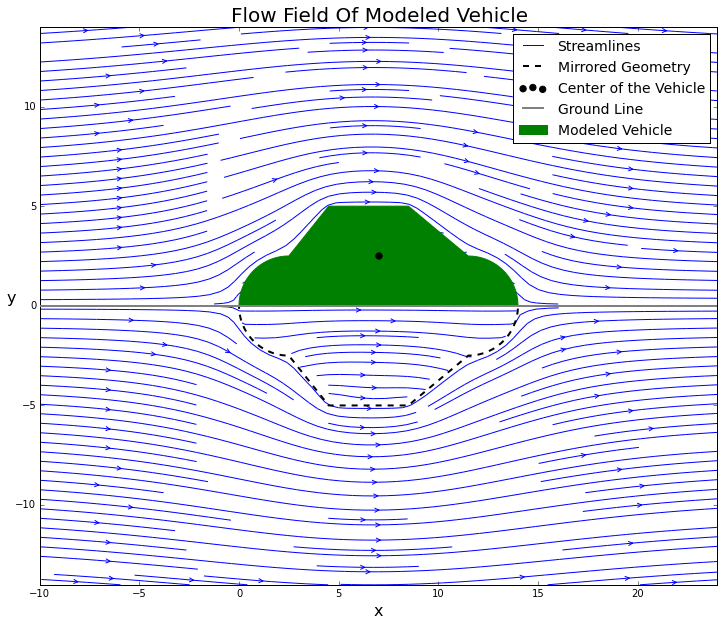

In [249]:
# Plotting flow field
size = 10
pl.figure(figsize=(size*(x_f-x_0)/(y_f-y_0), size))
pl.xlabel('x', fontsize=16)
pl.ylabel('y', fontsize=16,rotation='horizontal')
pl.title('Flow Field Of Modeled Vehicle', fontsize=20);
pl.xlim(x_0, x_f);
pl.ylim(y_0, y_f);

st1 = pl.streamplot(X, Y, U, V, density=2, linewidth=1, arrowsize=1, arrowstyle='->').lines;

l1, = pl.plot([xm[i] for i in range(0,len(xm)) if ym[i] <= 0.001], 
                [ym[i] for i in range(0,len(ym)) if ym[i] <= 0.001], 
                'k--', linewidth = 2, label='Mirrored Geometry')

#Plotting aesthetics
s1 = pl.scatter(x_center, y_center, marker = 'o', color='k', s=40, zorder=5, label='Center of the Vehicle')
h1 = pl.hlines(0, x_0, x_f, color = 'gray', linewidth = 2, zorder = 6, label='Ground Line')
f1, = pl.fill([xm[i] for i in range(0,len(xm)) if ym[i] >= 0], 
                [ym[i] for i in range(0,len(ym)) if ym[i] >= 0], 
                color='g', linestyle='solid', linewidth=1, zorder=3, label='Modeled Vehicle')

st1.set_label('Streamlines')
pl.legend(handles=[st1, l1, s1, h1, f1], loc='best', prop={'size':14});

**Figure 2: Flow Field of Modeled Vehicle**

Figure 2 shows the streamlines formed by the modeled vehicle in a 25 mph freestream flow. The blue lines are the streamlines, the gray line represents the ground, the black dashed line represents the mirrored geometry formed by the panels the filled green solid represents the modeled vehicle, and the center of the vehicle is marked by a black dot. From the figure, the mirrored geometry does allow the ground to be modeled as a streamline.

Iterates for the vertical distance from vehicle center to undisturbed flow. Criteria in this case is 1.01 of freestream velocity:

In [181]:
tol = 10**-8 #Tolerance
y_init1 = 5.1 #Initial y start
y_init2 = 40 #Initial y end
N_iter = 100 #Number of y-values to generate, also controls spacing
error = 1 #Initializes error

#Iterates until error is greater than tolerance
while error > tol:
    #Vehicle center to undisturbed flow on vertical line
    y_check = np.linspace(y_init1, y_init2, N_iter) #Generates y-range
    x_check = x_center       #x-location: for vertical line, also is x-location of center
    x_check, y_check = np.meshgrid(x_check, y_check) #Generate matrix to use existing function

    u_check, v_check = panel_velocity_field(pa, x_check, y_check) #Calculates velocities in the range
    u_uinf_v = (u_check + u_inf)/u_inf #Calculates x-velocity normalized by freestream velocity
    
    #If last normalized velocity value is greater than criteria
    if u_uinf_v[N_iter - 1] > 1.01:
        #Changes bounds for next iteration as follows:
        y_init1 = y_init2
        y_init2 = y_init2 + 10
    else:
        #Finds the first index when normalized velocity meets criteria
        loc_v = min([i for i in range(0, N_iter) if u_uinf_v[i] < 1.01])  
        #Calculates absolute error
        error = abs(u_uinf_v[loc_v] - 1.01)
        #Sets y-start as y-value for meeting criteria - 1 step
        y_init1 = y_check[loc_v] - (y_init2 - y_init1)/N_iter
        #Sets y-end as y-value for meeting criteria + 1 step
        y_init2 = y_check[loc_v] + (y_init2 - y_init1)/N_iter

In [182]:
print('Vertical distance from vehicle center to undisturbed flow:', y_check[loc_v])

Vertical distance from vehicle center to undisturbed flow: [ 52.40959148]


Using the given criteria, the vertical distance from the vehicle center to undisturbed flow is $52.41$ ft.

Iterates for the horizontal distance from vehicle center to undisturbed flow. Criteria in this case is 0.99 of freestream velocity:

In [178]:
tol = 10**-8 #Tolerance
x_init1 = 2.499 #Initial x start
x_init2 = 1 #Initial x end
N_iter = 100 #Number of x-values to generate, also controls spacing
error = 1 #Initializes error
#Iterates until error is greater than tolerance
while error > tol:
    #Vehicle center to undisturbed flow on vertical line
    x_check = np.linspace(x_init1, x_init2,N_iter) #Generates x-range
    y_check = y_center       #y-location: for horizontal line, also is y-location of center
    y_check, x_check = np.meshgrid(y_check, x_check) #Generate matrix to use existing function

    u_check, v_check = panel_velocity_field(pa, x_check, y_check) #Calculates velocities in the range
    u_uinf_h = (u_check + u_inf)/u_inf #Calculates x-velocity normalized by freestream velocity

    #If last normalized velocity value is less than criteria
    if u_uinf_h[N_iter - 1] < 0.99:
        #Changes bounds for next iteration as follows:
        x_init1 = x_init2
        x_init2 = x_init2 - 10
    else:
        #Finds the first index when normalized velocity meets criteria
        loc_h = min([i for i in range(0, N_iter) if u_uinf_h[i] > 0.99])  
        #Calculates absolute error
        error = abs(u_uinf_h[loc_h] - 0.99)
        #Sets y-start as y-value for meeting criteria - 1 step
        x_init1 = x_check[loc_h] - (x_init2 - x_init1)/N_iter
        #Sets y-end as y-value for meeting criteria + 1 step
        x_init2 = x_check[loc_h] + (x_init2 - x_init1)/N_iter

In [180]:
print('Horizontal distance from vehicle center to undisturbed flow:', x_check[loc_v])

Horizontal distance from vehicle center to undisturbed flow: [-45.61668325]


Using the given criteria, the horizontal distance from the vehicle center to undisturbed flow in front of the vehicle is $45.62$ ft.

In [243]:
print('(x,y) locations of undisturbed flow on surface:', [(x, y) for x, y in zip(x_loc, y_loc)])
print('Normalized velocities corresponding to each point:', [u_uinf[i] for i in loc])

(x,y) locations of undisturbed flow on surface: [(12.859731565365593, 2.0938029976992327), (1.6657688200996907, 2.3557961784904444), (1.307511875325567, 2.1962899099660085)]
Normalized velocities corresponding to each point: [1.0026873924108457, 1.0095947460676205, 0.99604411068796761]


Code to calculate x, y velocity components on surface of car:

In [25]:
pa_up = [p for p in pa if p.yc > 0]
u_surf, v_surf = panel_surface_vfield(pa_up)
N_up = len(pa_up)

u_uinf = np.array(u_surf,dtype=float)/u_inf

loc = []

for i in range(0,N_up):
    if (u_uinf[i] < 1.01) & (u_uinf[i] > 0.99):
        loc.append(i)

x_loc = [pa_up[i].xc for i in loc]
y_loc = [pa_up[i].yc for i in loc]


Finds normalized velocity ratios across mesh and plots locations containing undisturbed flow determined by the criteria:

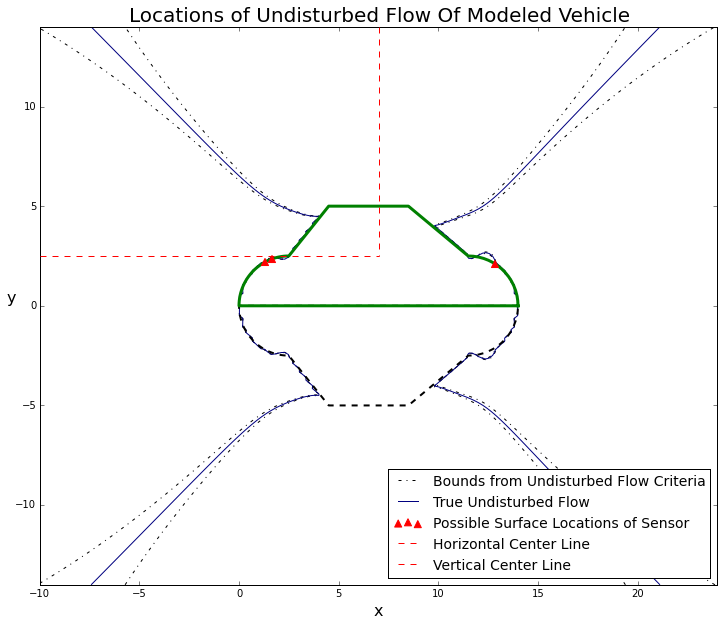

In [255]:
U_uinf = U/u_inf #Finds normalized velocity ratios across mesh

size = 10
pl.figure(figsize=(size*(x_f-x_0)/(y_f-y_0), size))
pl.xlabel('x', fontsize=16)
pl.ylabel('y', fontsize=16,rotation='horizontal')
pl.title('Locations of Undisturbed Flow Of Modeled Vehicle', fontsize=20);
pl.xlim(x_0, x_f);
pl.ylim(y_0, y_f);

ct_range = pl.contour(X, Y, U_uinf, 100, levels =[0.99, 1.01], colors ='k', linestyles ='-.').collections[0]
ct_free = pl.contour(X, Y, U_uinf, 100, levels =[1.00]).collections[0]


l1, = pl.plot([xm[i] for i in range(0,len(xm)) if ym[i] <= 0.001], 
                [ym[i] for i in range(0,len(ym)) if ym[i] <= 0.001], 
                'k--', linewidth = 2, label='Mirrored Geometry')

l2, = pl.plot([xm[i] for i in range(0,len(xm)) if ym[i] > -0.001], 
                [ym[i] for i in range(0,len(ym)) if ym[i] > -0.001], 
                'g', linewidth = 3, label='Car Geometry')

s1 = pl.scatter(x_loc, y_loc, marker = '^', color='r', s=50, zorder=5, label='Possible Surface Locations of Sensor')

h1 = pl.hlines(y_center, x_0, x_center, color = 'r', linestyle = '--', linewidth = 1, zorder = 6, label='Horizontal Center Line')
v1 = pl.vlines(x_center, y_f, y_center, color = 'r', linestyle = '--', linewidth = 1, zorder = 6, label='Vertical Center Line')

ct_range.set_label('Bounds from Undisturbed Flow Criteria')
ct_free.set_label('True Undisturbed Flow')
pl.legend(handles = [ct_range, ct_free, s1, h1, v1], loc='lower right', prop={'size':14});



**Figure 3: Locations of Undisturbed Flow of Modeled Vehicle**

Figure 3 shows the locations of undisturbed flow meeting the given criteria. Locations on the solid blue line has an x-velocity equal to the freestream, giving true undisturbed flow. The dashed-dotted line defines the given criteria for undisturbed flow. As a result, the locations within the two dashed lines contain undisturbed flow. The red triangles denote the location on the surface of the vehicle meeting the undisturbed flow criteria. The red dashed lines are vertical and horizontal lines from the center of the vehicle.

From the figure, undisturbed flow does not occur anywhere close to the vehicle above the center point or to the left of the center point. Undisturbed flow locations do occur in a line of about 45 degrees above the x-axis from the center point. Otherwise, the figure is inaccurate close to the surface so a calculation for the x-velocity is performed across the surface, giving the locations on the vehicle that meets the criteria for undisturbed flow. If the location needs to be close to a center line, the points in the front should be chosen. The location closest to the horizontal center line is at $(1.666, 2.356)$ with a normalized velocity ratio of $0.9960$ which is approximately 1.00.

---

### Problem 2: Airfoil Performance of Various Airfoils

#### Approach

The Reynolds number and the lift coefficient is calculated using the given values. The density ($\rho$) is found from Anderson's Fundamentals's Appendix E at 22,975 ft to be $1.1435E-3$ $\frac{slugs}{ft^3}$. For the lift coefficient at cruise, the lift force is equal to the weight. The lift coefficent is calculated based on a 3D wing while it is later reused as an airfoil lift coefficient.

The geometry data for the NACA 0012 airfoil is generated using XFOIL. The other airfoil's geometry data are given. These are read and plotted using NumPy and pyplot. Also using XFOIL, lift coefficient and drag coeffiicent data of each airfoil for invisicid and viscous flow is generated for angles of attack between -4 degrees to 30 degrees. These are again simply read and plotted using NumPy and pyplot.

From the data, the maximum coefficient of lift is found, then the angle of attack at stall is the angle of attack for the maximum coefficient of lift. This angle of attack is then used to obtain the drag coefficient at stall. Interpolation is used to find the angle of attack and the drag coefficient at the cruise condition. They are interpolated by finding the two lift coefficients closest to the design's lift coefficient.

#### Equations

The Reynolds number for an airfoil is defined by the following equation where $\rho$ is freestream density, $V$ is freestream velocity, $c$ is the chord length, and $\mu$ is freestream dynamic viscosity.

$$
Re_c = \frac{\rho Vc}{\mu}
$$

The coefficient of lift for a wing is defined by the following equation where $L$ is the lift force, $\rho$ is freestream density, $S$ is the wing area, and $V$ is freestream velocity.

$$
C_L = \frac{L}{0.5\rho S V^2}
$$

Given the design conditions at cruise, the Reynolds number can be calculated:

$$
Re_{cruise} = \frac{\rho V_{cruise} c}{\mu}
$$

At cruise, the airplane is at a steady level flight such that the lift force equals to the weight. From that, the lift coefficient at cruise is defined by the following equation, where $W$ is the weight of the aircraft.

$$
C_{l, cruise} \approx C_{L,cruise} = \frac{W}{0.5 \rho V_{cruise} ^2 S}
$$

A linear interpolation equation is used to find the angle of attack at cruise and the drag coefficient at cruise. They are defined as follows where $i$ is an index in the list of data, and in between $C_{l_i}$ and $C_{l_{i+1}}$ is $C_{l, cruise}$.

$$
\alpha_{cruise} \approx \left(\alpha_{i+1} - \alpha_{i}\right)
\left(\frac{C_{l, cruise} - C_{l_{i}}}{C_{l_{i+1}} - C_{l_{i}}}\right)
+ \alpha_i
$$

$$
C_{d, cruise} \approx \left(C_{d_{i+1}} - C_{d_{i}}\right)
\left(\frac{C_{l, cruise} - C_{l_{i}}}{C_{l_{i+1}} - C_{l_{i}}}\right)
+ C_{d_i}
$$



#### Code and Results

##### Part A

---

Code to calculate the Reynold's number of lift coefficient at cruise:

In [5]:
S = 235 #Wing area in ft^2
c = 8.48 #Root chord length in ft
V_cruise = 362*5280/(60*60) #Velocity in ft/s

W = 9200 #lbf
mu = 3.25*10**(-7) #Slugs per ft*s
rho = 1.1435*10**(-3) #Slugs per ft^3
#T = 436.76 #Degrees Rankine
#R_air = 1716 #lbf ft per slug*Rankin
#Ma = V_cruise/(1.4*R_air*T)**(1/2)

Re = rho*V_cruise*c/mu

Cl_cruise = W/(0.5*rho*S*V_cruise**2)

print('Design Reynold''s Number:', Re)
print('Coefficient of Lift at Cruise:', Cl_cruise)

Design Reynolds Number: 15841220.988717949
Coefficient of Lift at Cruise: 0.24290351934641993


The design's Reynolds number is $15.84(10^6)$, and the lift coefficient at cruise is $0.2429$.

---

##### Part B

---

Obtains geometry data and converts to real airfoil with a chord length of 8.48 ft:

In [3]:
#NACA 0012 data (1)
#Geometry data
x_1, y_1 = 8.48*np.genfromtxt('data/NACA0012.dat', skip_header = 1, unpack = True)
#Invisid (i) data
a_1i, Cl_1i, Cd_1i = np.genfromtxt('data/NACA0012_inviscid.dat', skip_header = 2, unpack = True)
#Viscous (v) data
a_1v, Cl_1v, Cd_1v = np.genfromtxt('data/NACA0012_viscous.dat', skip_header = 2, unpack = True)

#P-51D data (2)
x_2, y_2 = 8.48*np.genfromtxt('data/p51d.dat', skip_header = 1, unpack = True)
a_2i, Cl_2i, Cd_2i = np.genfromtxt('data/p51d_inviscid.dat', skip_header = 2, unpack = True)
a_2v, Cl_2v, Cd_2v = np.genfromtxt('data/p51d_viscous.dat', skip_header = 2, unpack = True)

#NLF 414F (3)
x_3, y_3 = 8.48*np.genfromtxt('data/nlf414f.dat', skip_header = 1, unpack = True)
a_3i, Cl_3i, Cd_3i = np.genfromtxt('data/nlf414f_inviscid.dat', skip_header = 2, unpack = True)
a_3v, Cl_3v, Cd_3v = np.genfromtxt('data/nlf414f_viscous.dat', skip_header = 2, unpack = True)

Plots NACA 0012 geometry:

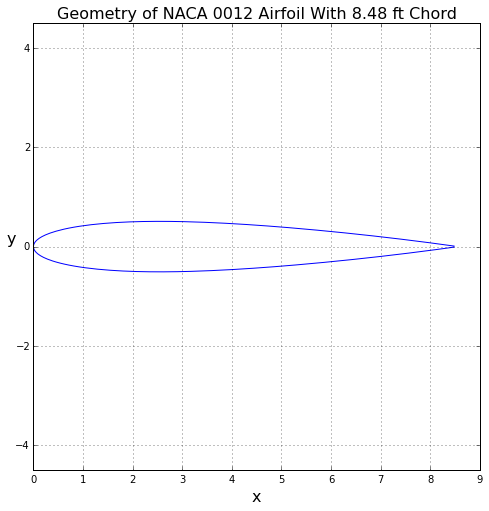

In [185]:
size = 8 #Figure's size

pl.figure(figsize = (size,size))
pl.xlabel('x', fontsize=16)
pl.ylabel('y', fontsize=16,rotation='horizontal')
pl.grid(True)
pl.title('Geometry of NACA 0012 Airfoil With 8.48 ft Chord', fontsize=16);
pl.plot(x_1, y_1)
pl.axis('equal');

**Figure 4: Geometry of NACA 0012 Airfoil With 8.28 ft Chord**

Figure 4 contains a plot of the geometry of a true NACA 0012 airfoil with a chord of 8.28 ft.

Plots P-51D geometry:

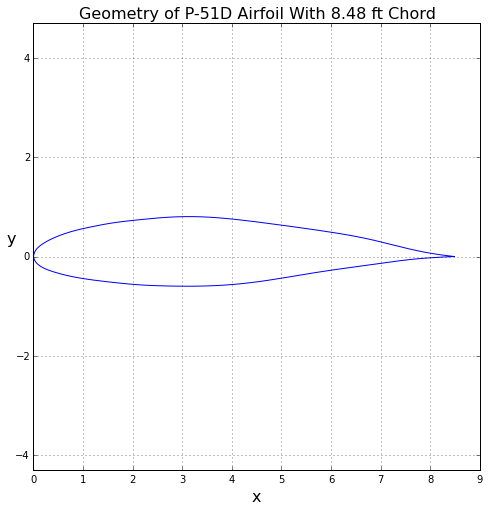

In [186]:
pl.figure(figsize = (size,size))
pl.xlabel('x', fontsize=16)
pl.ylabel('y', fontsize=16,rotation='horizontal')
pl.grid(True)
pl.title('Geometry of P-51D Airfoil With 8.48 ft Chord', fontsize=16);
pl.plot(x_2, y_2)
pl.axis('equal');

**Figure 5: Geometry of  P-51D Airfoil With 8.28 ft Chord**

Figure 5 contains a plot of the geometry of a true P-51D airfoil with a chord of 8.28 ft.

Plots NLF 414F geometry:

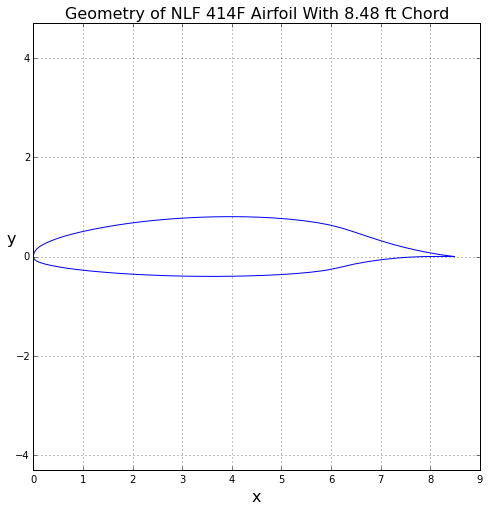

In [187]:
pl.figure(figsize = (size,size))
pl.xlabel('x', fontsize=16)
pl.ylabel('y', fontsize=16,rotation='horizontal')
pl.grid(True)
pl.title('Geometry of NLF 414F Airfoil With 8.48 ft Chord', fontsize=16);
pl.plot(x_3, y_3)
pl.axis('equal');

**Figure 6: Geometry of NLF 414F Airfoil With 8.28 ft Chord**

Figure 6 contains a plot of the geometry of a true NLF 414F airfoil with a chord of 8.28 ft.

Plots Lift Curves:

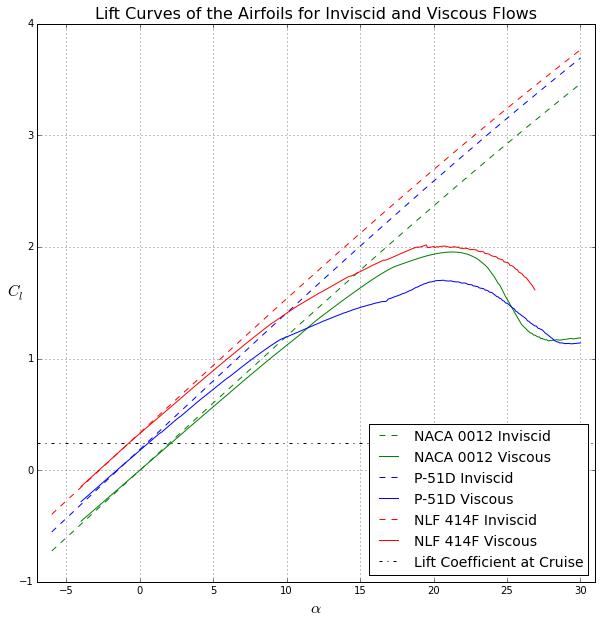

In [224]:
size = 10 #Figure's size
pl.figure(figsize = (size,size))
pl.xlabel('$\\alpha$', fontsize=16)
pl.ylabel('$C_l$', fontsize=16,rotation='horizontal')
pl.grid(True)
pl.xlim(-7,31)
pl.title('Lift Curves of the Airfoils for Inviscid and Viscous Flows', fontsize=16);

l1, = pl.plot(a_1i, Cl_1i, 'g--', label= 'NACA 0012 Inviscid')
l2, = pl.plot(a_1v, Cl_1v, 'g', label='NACA 0012 Viscous')
l3, = pl.plot(a_2i, Cl_2i, 'b--', label= 'P-51D Inviscid')
l4, = pl.plot(a_2v, Cl_2v, 'b', label= 'P-51D Viscous')
l5, = pl.plot(a_3i, Cl_3i, 'r--', label= 'NLF 414F Inviscid')
l6, = pl.plot(a_3v, Cl_3v, 'r', label= 'NLF 414F Viscous')

h1 = pl.hlines(Cl_cruise,-7, 31, linestyle = '-.', label='Lift Coefficient at Cruise')

pl.legend(handles=[l1, l2, l3, l4, l5, l6, h1], loc='lower right', prop={'size':14});

**Figure 7: Lift Curves of the Airfoils for Inviscid and Viscous Flows**

Figure 7 contains a plot of the lift curves for each airfoil. Green lines represent the NACA 0012 airfoil, blue lines represent the P-51D airfoil, and red lines represent the NLF 414F airfoil. The dashed lines use data from invisicid flows, and the solid lines use data from viscous flows. The dashed-dot line is the value of the lift coefficient at cruise from Part A.

The NLF 414F has the best lift performance at all angles of attack and in both inviscid and viscous flow. On the other hand, the P-51D airfoil has the second best lift performance in inviscid flow but only performs better than the NACA 0012 airfoil in viscous flow at low angles of attack. The NACA 0012 airfoil has the worst lift performance in inviscid flow but performs better than the P-51D airfoil in viscous flow at high angles of attack.

Plots Drag Polars:

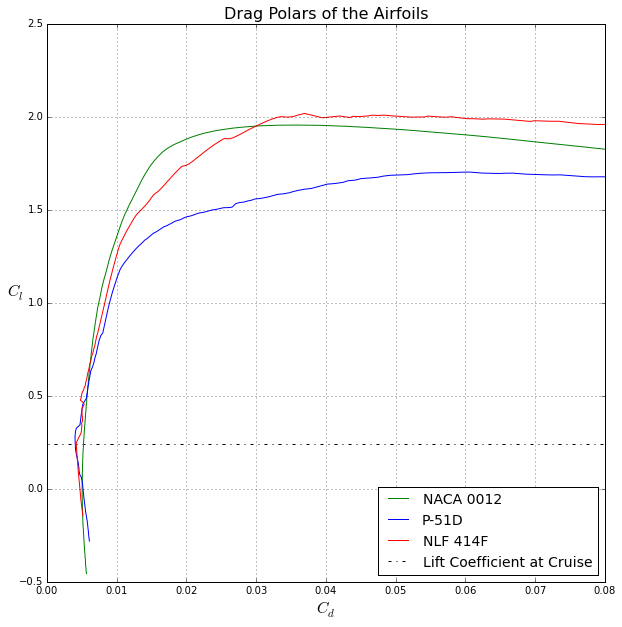

In [266]:
pl.figure(figsize = (size,size))
pl.xlabel('$C_d$', fontsize=16)
pl.ylabel('$C_l$', fontsize=16,rotation='horizontal')
pl.grid(True)
pl.title('Drag Polars of the Airfoils', fontsize=16);

l1, = pl.plot(Cd_1v, Cl_1v, 'g', label='NACA 0012')
l2, = pl.plot(Cd_2v, Cl_2v, 'b', label= 'P-51D')
l3, = pl.plot(Cd_3v, Cl_3v, 'r', label= 'NLF 414F')

h1 = pl.hlines(Cl_cruise,-7, 31, linestyle = '-.', label='Lift Coefficient at Cruise')

legend = pl.legend(handles=[l1, l2, l3, h1], loc='lower right', prop={'size':14});
pl.xlim(0.0,0.08);

**Figure 8: Drag Polars of the Airfoils**

Figure 8 contains a plot of the drag polars for each airfoil. The green line represent the NACA 0012 airfoil, the blue line represent the P-51D airfoil, and the red line represent the NLF 414F airfoil. The dashed-dot line is the value of the lift coefficient at cruise from Part A.

At cruise conditions, the P-51D has the best lift-drag ratio. The NLF 414F comes in second place, and the NACA 0012 comes in last. As lift increases, the NACA 0012 airfoil has the best lift-drag ratio but flatines earlier before the other two airfoils. The NLF 414F's lift-drag ratio beats the P-51D lift-drag ratio for most point after the cruise conditions.

---

##### Part C

---

Calculations for the NACA 0012 airfoil:

In [23]:
N_1 = len(Cl_1v) #Number of data points
Cl_1_max = max(Cl_1v) #Finds max lift coeff


#Iterates through lift coeff data to find index with max lift
for i in range(0, N_1):
    if Cl_1v[i] == Cl_1_max:
        loc_1 = i        #location of max life coeff

#Obtains angle of attack at stall which is angle of attack with max lift
a_1st = a_1v[loc_1]
#Obtains drag coeff at stall
Cd_1st = Cd_1v[loc_1]

#Iterates through lift coeff data until max lift coeff to find cruise lift coeff
for i in range(0, loc_1):
    if (Cl_1v[i] < Cl_cruise) & (Cl_1v[i+1] > Cl_cruise):
        loc_1a = i  #Indices of 2 lift coeff data between which contains Cl_cruise
        loc_1b = i+1
        
#Interpolates for alpha cruise and drag coeff at cruise
a_1cr = ((Cl_cruise - Cl_1v[loc_1a])/(Cl_1v[loc_1b] - Cl_1v[loc_1a]))*(a_1v[loc_1b]-a_1v[loc_1a]) + a_1v[loc_1a]
Cd_1cr = ((Cl_cruise - Cl_1v[loc_1a])/(Cl_1v[loc_1b] - Cl_1v[loc_1a]))*(Cd_1v[loc_1b]-Cd_1v[loc_1a]) + Cd_1v[loc_1a]

#Obtains max of lift-drag coeff ratio
Cl_Cd_1_max = max(Cl_1v/Cd_1v)

In [24]:
print('For the NACA 0012 airfoil,')
print('Maximum lift coefficient:', Cl_1_max)
print('Angle of attack at stall:',  a_1st)
print('Drag coefficient at stall:', Cd_1st)
print('Angle of attack at cruise:', a_1cr)
print('Drag coefficient at cruise:', Cd_1cr)
print('Maximum lift-drag coefficients ratio:', Cl_Cd_1_max)

For the NACA 0012 airfoil,
Maximum lift coefficient: 1.9552
Angle of attack at stall: 21.3
Drag coefficient at stall: 0.03583
Angle of attack at cruise: 2.12546946795
Drag coefficient at cruise: 0.00526764084039
Maximum lift-drag coefficients ratio: 137.511210762


Calculations for the P-51D airfoil:

In [17]:
N_2 = len(Cl_2v) #Number of data points
Cl_2_max = max(Cl_2v) #Finds max lift coeff

#Iterates through lift coeff data to find index with max lift
for i in range(0, N_2):
    if Cl_2v[i] == Cl_2_max:
        loc_2 = i       #location of max life coeff
        
#Obtains angle of attack at stall which is angle of attack with max lift
a_2st = a_2v[loc_2]
#Obtains drag coeff at stall
Cd_2st = Cd_2v[loc_2]

#Iterates through lift coeff data until max lift coeff to find cruise lift coeff
for i in range(0, loc_2):
    if (Cl_2v[i] < Cl_cruise) & (Cl_2v[i+1] > Cl_cruise):
        loc_2a = i  #Indices of 2 lift coeff data between which contains Cl_cruise
        loc_2b = i+1

#Interpolates for alpha cruise and drag coeff at cruise
a_2cr = ((Cl_cruise - Cl_2v[loc_2a])/(Cl_2v[loc_2b] - Cl_2v[loc_2a]))*(a_2v[loc_2b]-a_2v[loc_2a]) + a_2v[loc_2a]
Cd_2cr = ((Cl_cruise - Cl_2v[loc_2a])/(Cl_2v[loc_2b] - Cl_2v[loc_2a]))*(Cd_2v[loc_2b]-Cd_2v[loc_2a]) + Cd_2v[loc_2a]

Cl_Cd_2_max = max(Cl_2v/Cd_2v)

In [18]:
print('For the P-51D airfoil,')
print('Maximum lift coefficient:', Cl_2_max)
print('Angle of attack at stall:',  a_2st)
print('Drag coefficient at stall:', Cd_2st)
print('Angle of attack at cruise:', a_2cr)
print('Drag coefficient at cruise:', Cd_2cr)
print('Maximum lift-drag coefficients ratio:', Cl_Cd_2_max)

For the P-51D airfoil,
Maximum lift coefficient: 1.7025
Angle of attack at stall: 20.7
Drag coefficient at stall: 0.06061
Angle of attack at cruise: 0.573715081986
Drag coefficient at cruise: 0.0040752569836
Maximum lift-drag coefficients ratio: 112.680937819


Calculations for the NLF 414F airfoil:

In [25]:
N_3 = len(Cl_3v) #Number of data points
Cl_3_max = max(Cl_3v) #Finds max lift coeff

#Iterates through lift coeff data to find index with max lift
for i in range(0,N_3):
    if Cl_3v[i] == Cl_3_max:
        loc_3 = i       #location of max life coeff

#Obtains angle of attack at stall which is angle of attack with max lift
a_3st = a_3v[loc_3]
#Obtains drag coeff at stall
Cd_3st = Cd_3v[loc_3]

#Iterates through lift coeff data until max lift coeff to find cruise lift coeff
for i in range(0, loc_3):
    if (Cl_3v[i] < Cl_cruise) & (Cl_3v[i+1] > Cl_cruise):
        loc_3a = i  #Indices of 2 lift coeff data between which contains Cl_cruise
        loc_3b = i+1

#Interpolates for alpha cruise and drag coeff at cruise
a_3cr = ((Cl_cruise - Cl_3v[loc_3a])/(Cl_3v[loc_3b] - Cl_3v[loc_3a]))*(a_3v[loc_3b]-a_3v[loc_3a]) + a_3v[loc_3a]
Cd_3cr = ((Cl_cruise - Cl_3v[loc_3a])/(Cl_3v[loc_3b] - Cl_3v[loc_3a]))*(Cd_3v[loc_3b]-Cd_3v[loc_3a]) + Cd_3v[loc_3a]
        
#Interpolates for alpha cruise and drag coeff at cruise
Cl_Cd_3_max = max(Cl_3v/Cd_3v)

In [26]:
print('For the NLF 414F airfoil,')
print('Maximum lift coefficient:', Cl_3_max)
print('Angle of attack at stall:',  a_3st)
print('Drag coefficient at stall:', Cd_3st)
print('Angle of attack at cruise:', a_3cr)
print('Drag coefficient at cruise:', Cd_3cr)
print('Maximum lift-drag coefficients ratio:', Cl_Cd_3_max)

For the NLF 414F airfoil,
Maximum lift coefficient: 2.0179
Angle of attack at stall: 19.5
Drag coefficient at stall: 0.03692
Angle of attack at cruise: -0.754207463166
Drag coefficient at cruise: 0.00424373776105
Maximum lift-drag coefficients ratio: 125.520628684


At stall, the NACA 0012 airfoil has the least drag coefficient, the largest angle of attack, and the second best maximum lift coefficient. The P-51D airfoil has the highest drag coefficient, the second largest angle of attack, and the worst maximum lift coefficient. Lastly, the NLF 414F airfoil has the second largest drag coefficient, smallest angle of attack, and the best maximum lift coefficient.

At the given cruise condition, the NACA 0012 airfoil has the highest angle of attack, and highest drag coefficient. The P-51D airfoil has the second highest angle of attack, and the lowest drag coefficient. And the NLF 414F has the least angle of attack and moderate drag coefficient.

From the drag polars, the NACA 0012 has the highest lift-drag ratio, the P-51D has the lowest lift-drag ratio, and the NLF 414F has a moderate lift-drag ratio. The trend in the lift-drag ratios corresponds to the trend in the drag coefficient at stall, and the locations of the maximum camber. For a greater x-distance from the leading edge, the larger the lift-drag ratio an airfoil has.

At stall, with the least drag, largest angle of attack, and moderate maximum lift coefficient, an aircraft with the NACA 0012 airfoil can allow agile maneuvres with a steep climb and high amount of thrust to contribute to lift instead of overcoming drag. The moderate maximum lift coefficient and large angle of attack allows a large range of velocities to cruise at. But at the same time, a moderate maximum lift restricts the weight of the aircraft. At the design condition, a NACA 0012 airfoil is not recommended because of the high drag coefficient. However, the angle of attack is fine because this airfoil also has the largest angle of attack at stall.

For the P-51D airfoil at stall, the high drag and low maximum lift coefficient restricts the performance of the aircraft because a big engine is needed to overcome drag but not enough lift can be generated to cruise at high speeds. Although the range of angles of attack is not the best, at 0 degrees, the P-51D airfoil can generate lift. At the design condition, a P-51D airfoil is recommended because of the low drag coefficient. The angle of attack is again not a problem but is better than the NACA 0012 airfoil in that the P-51D airfoil at these conditions is 20.1 degrees from stall.

For the NLF 414F airfoil at stall, the combination of small angle of attack and best maximum lift coefficient allows the aircraft to cruise with most of the thrust overcoming drag. This allows a lighter engine to be used, and the relieved weight can be refilled with other thinigs, maintaining the lift coefficient at high speeds. But the small angle of attack means that the aircraft cannot maneuvre as well. At the design conditoin, the NLF 414F airfoil can be used becfause of its low angle of attack, reducing the complexity of the aircraft's control system in maintaining the angle of attack.

Based on the results, the P-51D performs best under the given design conditions because of its low drag and far away from the angle of attack at stall.

---

## Conclusion

The source panel method is an effective analytical tool for any shape submersed in air. For the modeled car, the resultant flow field correctly envelops the car so the resultant locations for undisturbed flow should be accurate. For this model, the horizontal and vertical distance to undisturbed flow is far away. But there are closer locations at a 45 degree angle or even closer locations directly at the surface.

For the airfoil performance, even when the overall data shows otherwise, an airfoil that is designed for a specific set of conditions will perform the best at that set of conditions. The data shows that P-51D should have the worst overall performance but is the best airfoil for the given design conditions. In addition, the relationship between maximum camber and maximum lift-drag ratio is evident in the data. Even with the different maximum camber locations and assymmetries, a balanced airfoil like the NACA 0012 can perform well in many designs because its performance parameters counteracts each other.